In [1]:
import sys

sys.path.insert(0,'./')
# from importlib import reload

In [2]:
from lensing_lensing import *
from fisher import *

In [3]:
def fisher_calc(params=['As'],Nx=3,dx_max=0.01,do_log=False,kappa_class=None):
    cosmo_fid=kappa_class.Ang_PS.PS.cosmo_params.copy()
    
    cl0G=kappa_class.kappa_cl_tomo()
    cl_t=cl0G['stack'].compute()
    cov=cl_t['cov']
    kappa_class.Ang_PS.reset()
    kappa_class.do_cov=False

    Dx=np.linspace((1-dx_max),(1+dx_max),Nx)
    ndim=len(params)
    
    x_vars={}
    models={}
    model_derivs={}
    covs={}
    for p in params:
        x0=cosmo_fid[p]
        if do_log:
            x0=np.absolute(x0)
            x_vars[p]=x0**Dx
            if x0==1:
                x_vars[p]=(2.**Dx)/2. # 1**x=1
            x_vars[p]*=np.sign(cosmo_fid[p])
        else:
            x_vars[p]=x0*Dx #np.linspace(x0*(1-dx_max),x0*(1+dx_max),Nx)
        
        models[p]={}
#         covs[p]={}
        model_derivs[p]={}
        for i in np.arange(Nx):
            cosmo_t=cosmo_fid.copy()
            cosmo_t[p]=x_vars[p][i]
            cl0G=kappa_class.kappa_cl_tomo(cosmo_params=cosmo_t)
            cl_t=cl0G['stack'].compute()
            models[p][i]=cl_t['cl']
#             covs[p][i]=cl_t['cov']
            kappa_class.Ang_PS.reset()
        model_derivs[p]=models[p][Nx-1]-models[p][0]
        if do_log:
            model_derivs[p]/=np.log(x_vars[p][Nx-1]/x_vars[p][0])
        else:
            model_derivs[p]/=(x_vars[p][Nx-1]-x_vars[p][0])
#     cov=covs[p][1]
    cov_inv=np.linalg.inv(cov)
    cov_p_inv=np.zeros([ndim]*2)
    i1=0
    for p1 in params:
        i2=0
        for p2 in params:
            cov_p_inv[i1,i2]=np.dot(model_derivs[p1],np.dot(cov_inv,model_derivs[p2]))
            i2+=1
        i1+=1
    print (cov_p_inv)
    out={}
    out['cov_p']=np.linalg.inv(cov_p_inv)
    out['error']=np.sqrt(np.diag(out['cov_p']))
    return out

In [4]:
lmax_cl=2000
lmin_cl=2
l_step=3 #choose odd number
l=np.arange(lmin_cl,lmax_cl,step=l_step)
l0=np.arange(lmin_cl,lmax_cl)
#l_bins=np.int64(np.linspace(lmin_cl,lmax_cl,20))#
lmin_clB=lmin_cl+10
lmax_clB=lmax_cl-10
Nl_bins=40
l_bins=np.int64(np.logspace(np.log10(lmin_clB),np.log10(lmax_clB),Nl_bins))
lb=np.sqrt(l_bins[1:]*l_bins[:-1])
if l_step!=1:
    l=np.unique(np.int64(np.logspace(np.log10(lmin_cl),np.log10(lmax_cl),Nl_bins*20)))

do_cov=True
bin_cl=True

bin_xi=True
theta_bins=np.logspace(np.log10(1./60),1,20)
stack_data=False

In [5]:
zs_bin1=source_tomo_bins(zp=[1],p_zp=np.array([1]),ns=26)

(array([0, 1]), array([1]), array([ 0.9999,  1.0001]))


/Users/Deep/anaconda/lib/python2.7/site-packages/astropy/units/quantity.py:1076: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__rtruediv__(other)


In [12]:
import lensing_lensing
reload(lensing_lensing)
from lensing_lensing import *

In [13]:
l.shape

(444,)

In [14]:
kappa0=Kappa(zs_bins=zs_bin1,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0,
               stack_data=stack_data,SSV_cov=True,tidal_SSV_cov=True,)#f_sky=0.35,sigma_gamma=0.37)
kappa1=Kappa(zs_bins=zs_bin1,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l,#np.int32((l[1:]+l[:-1])*0.5),
               stack_data=stack_data,SSV_cov=True,tidal_SSV_cov=True,)#f_sky=0.35)

# l are different in kappa0 and kappa1. To test if we can get aways with computation at fewer l, when binning
# with l_bins. Remeber, cl and cov are computed at some l first and then binned.

In [15]:
%time cl0G=kappa0.kappa_cl_tomo()
%time cl1G=kappa1.kappa_cl_tomo()#kappa1.kappa_cl_tomo()
# cl0G['stack'].visualize()

CPU times: user 10.1 ms, sys: 2.62 ms, total: 12.8 ms
Wall time: 10.5 ms
CPU times: user 11.1 ms, sys: 1.42 ms, total: 12.5 ms
Wall time: 11.5 ms


In [16]:
%time cl0=cl0G['stack'].compute()
cov_inv=np.linalg.inv(cl0['cov'])

SN=np.sqrt(np.dot(cl0['cl'],np.dot(cov_inv,cl0['cl'])))
SN

CPU times: user 12.9 s, sys: 319 ms, total: 13.2 s
Wall time: 13 s


204.38011319659415

In [17]:
cl0={}
cl1={}
%time cl0['cl']=cl0G['cl'].compute()
%time cl0['cov']=kappa0.compute_cov_tomo(cl0G['cov'])
%time cl1['cl']=cl1G['cl'].compute()
%time cl1['cov']=kappa1.compute_cov_tomo(cl1G['cov'])

CPU times: user 9.21 ms, sys: 3.68 ms, total: 12.9 ms
Wall time: 9.9 ms
CPU times: user 499 ms, sys: 77.6 ms, total: 577 ms
Wall time: 293 ms
CPU times: user 12.3 s, sys: 202 ms, total: 12.5 s
Wall time: 12.5 s
CPU times: user 24.9 ms, sys: 9.98 ms, total: 34.8 ms
Wall time: 42.2 ms


In [21]:
cc=kappa0.cov_utils

/Users/Deep/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


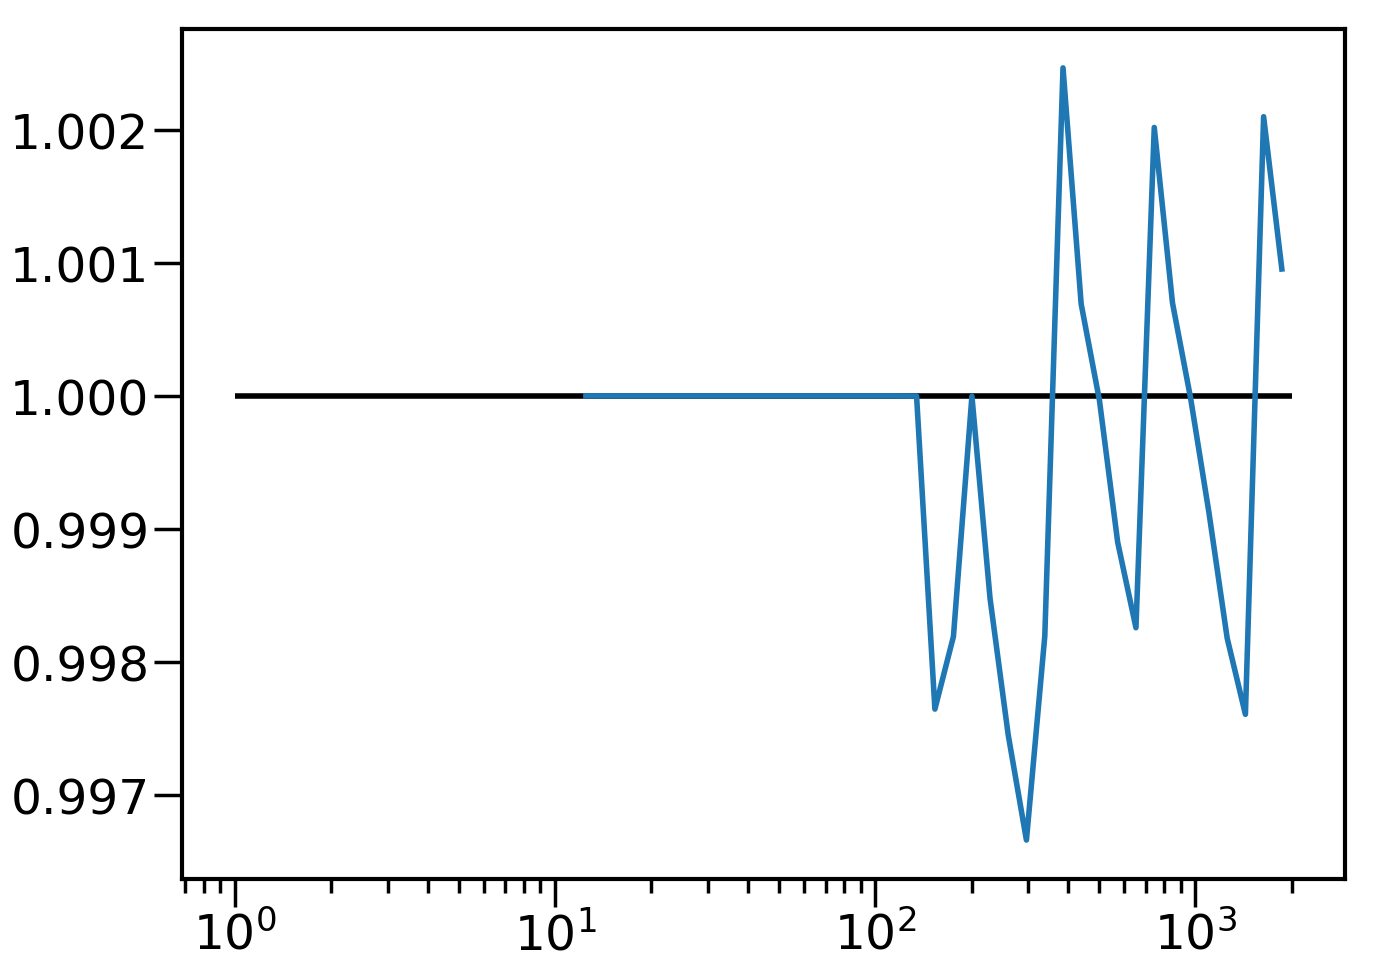

In [22]:
cl_t=cl0['cl'][:,0,0]
cl_t2=cl1['cl'][:,0,0]
plot(lb,cl_t/cl_t2)
hlines(1,1,2000)
xscale('log')
# ylim(8e-7,8.6e-7)
# yscale('log')

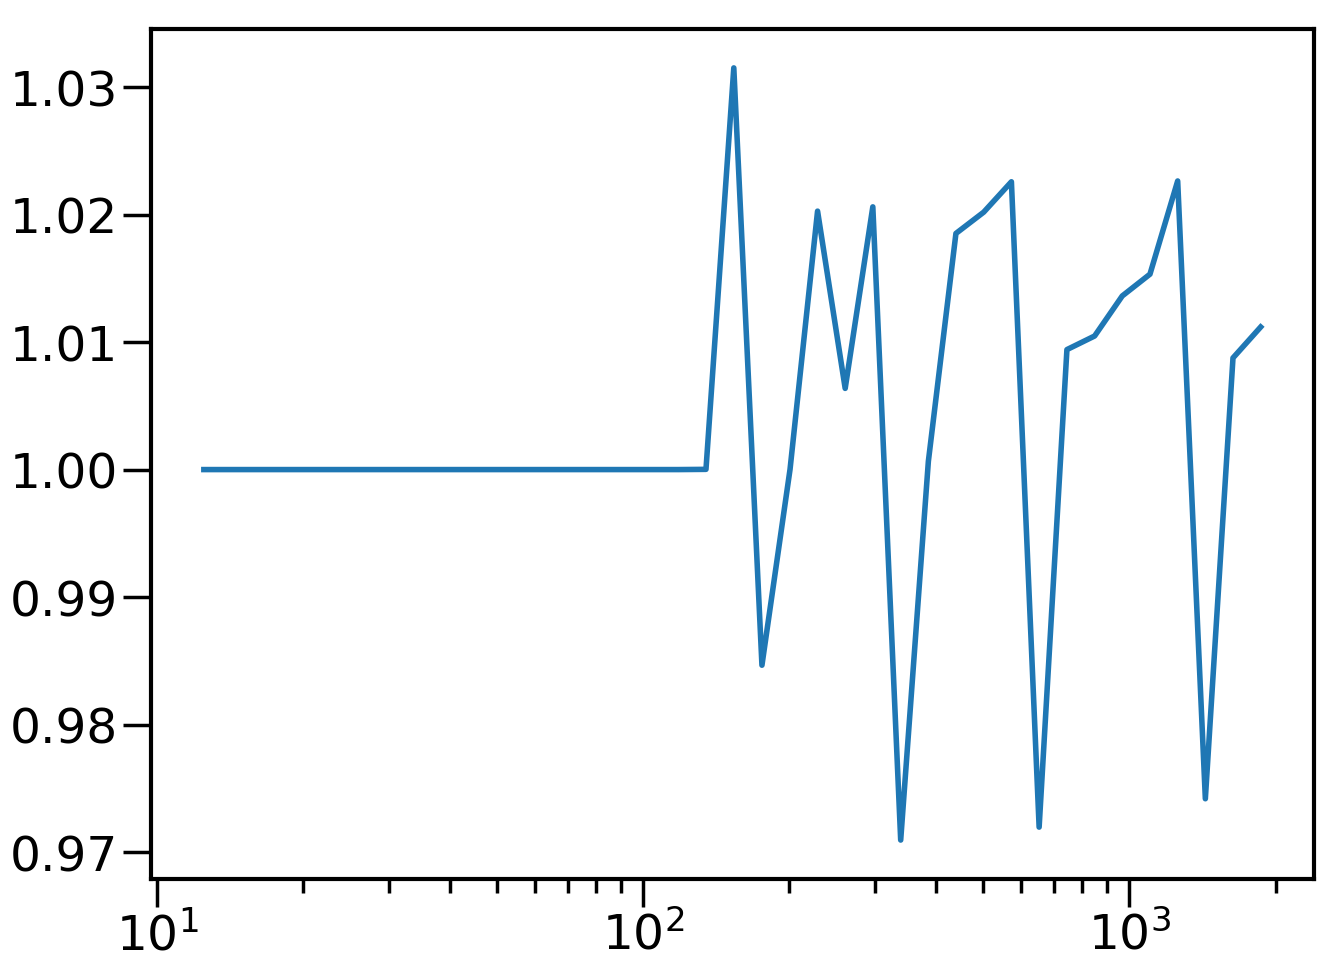

In [23]:
cov0=cl0['cov'][(0,0,0,0)]
cov02=cl1['cov'][(0,0,0,0)]
plot(lb,np.diag(cov02['G'])/np.diag(cov0['G']))
# plot(l,np.gradient(l))
xscale('log')
# yscale('log')
#ylim(0.99,1.01)

(10, 3000)

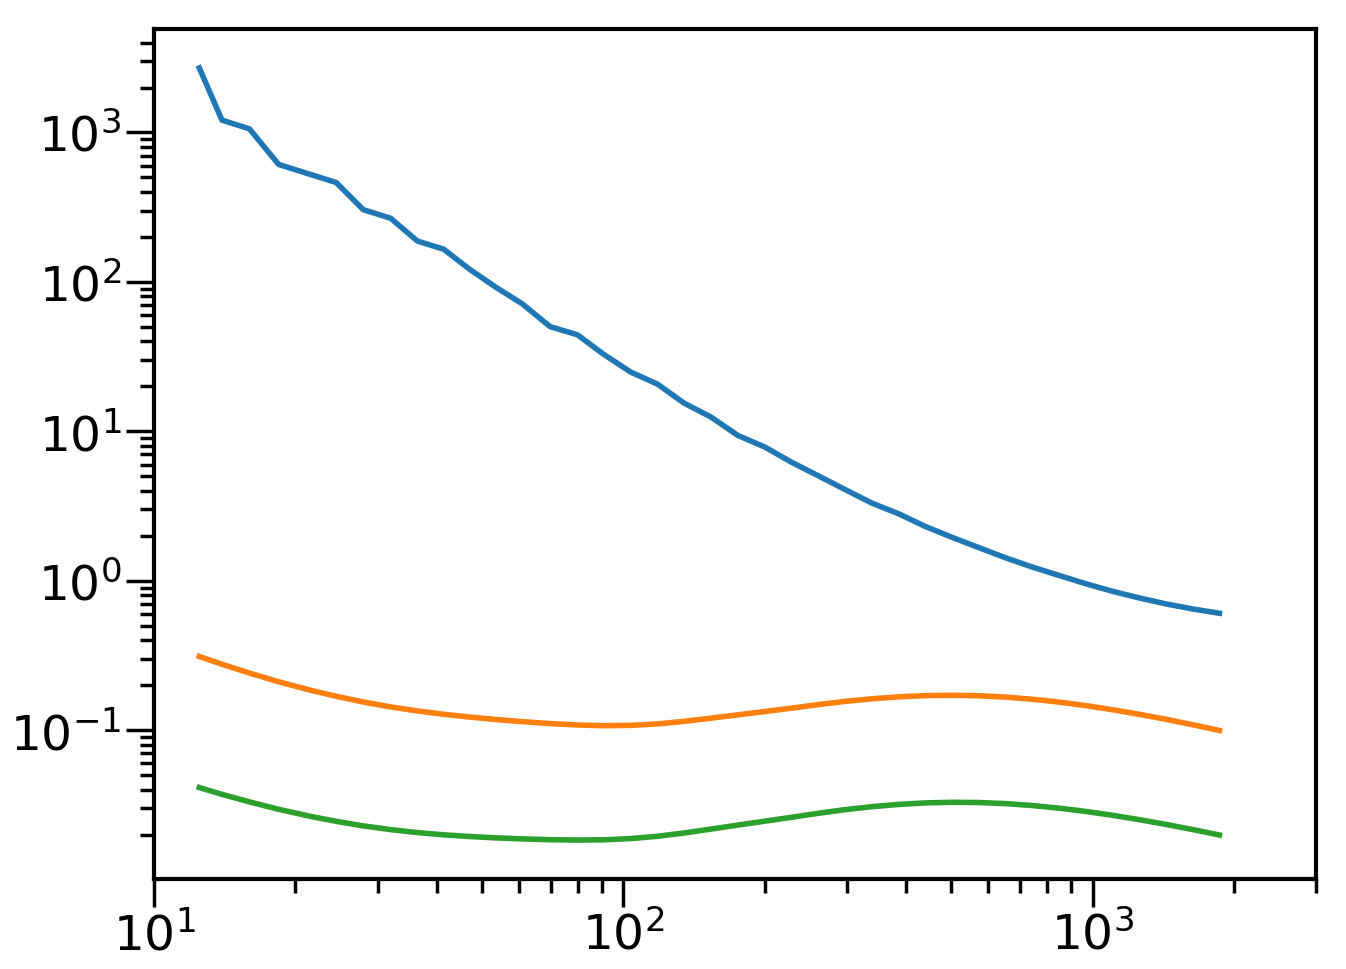

In [24]:
cov0=cl0['cov'][(0,0,0,0)]
f=1.e4
plot(lb,np.diag(cov0['G'])/cl_t**2*f)
#plot(lb,np.diag(cov02['G'])/cl_t**2*f*0.95)
plot(lb,np.diag(cov0['SSC_dd'])/cl_t**2*f)
plot(lb,np.diag(cov0['SSC_dk'])/cl_t**2*f)
xscale('log')
yscale('log')
xlim(10,3000)

(12, 1990)

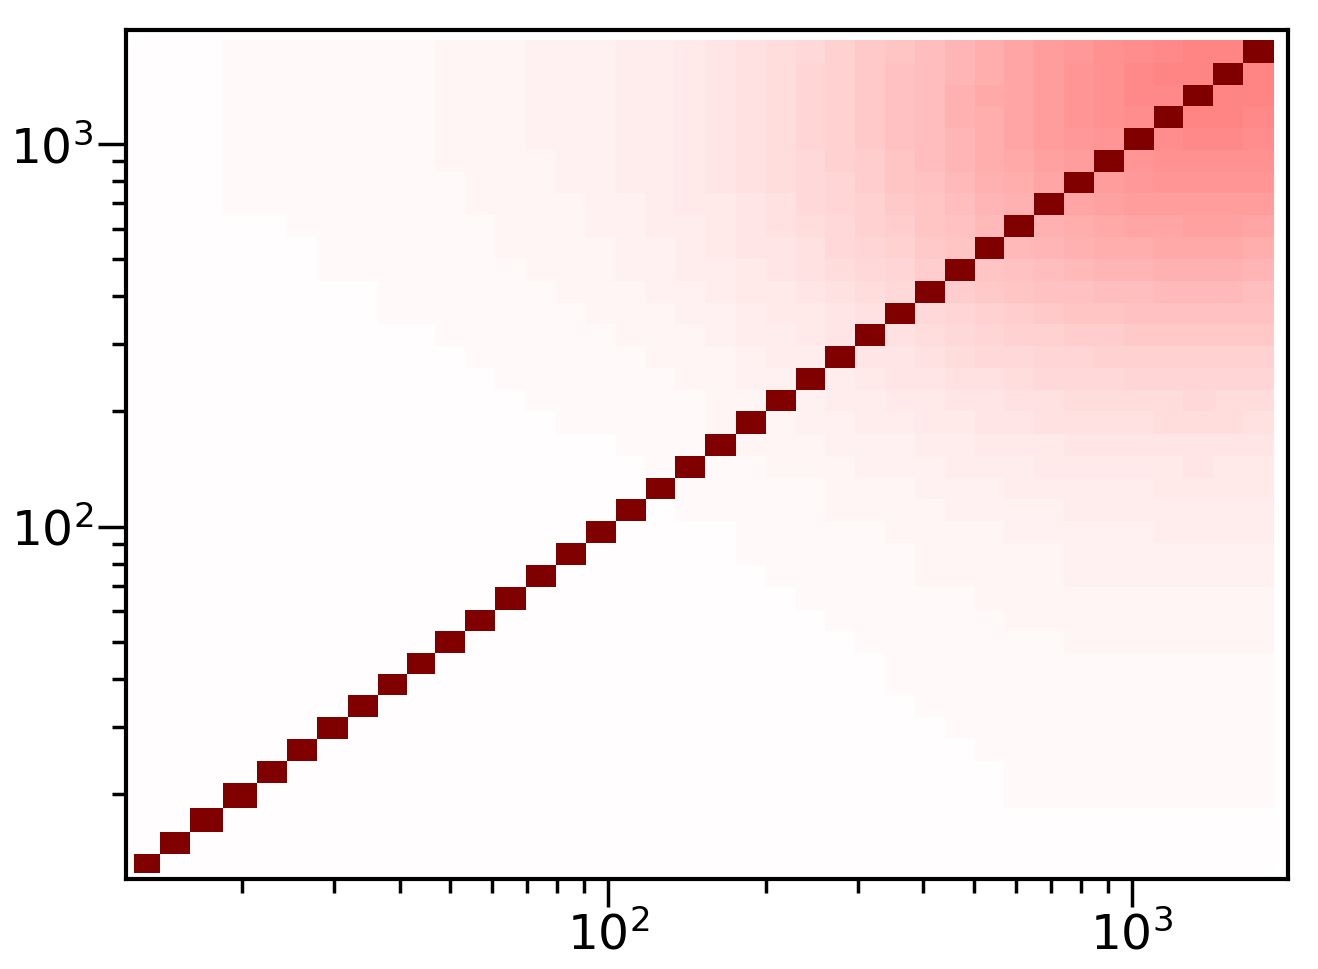

In [15]:
cov0=cl0['cov'][(0,0,0,0)]
corr2=kappa0.cov_utils.corr_matrix(cov0['final'])
pcolor(lb,lb,corr2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
xlim(lmin_clB,lmax_clB)
ylim(lmin_clB,lmax_clB)

In [18]:
import lensing_utils
reload(lensing_utils)

import lsst_utils
reload(lsst_utils)
from lsst_utils import *

import lensing_lensing
reload(lensing_lensing)

from lensing_lensing import *



In [19]:
do_xi=False
bin_xi=True
bin_cl=True
th_bins=np.logspace(-1,1,20)

In [20]:
zmin=0.3
zmax=2
z=np.linspace(0,5,200)
pzs=lsst_pz_source(z=z)
x=z<zmax
x*=z>zmin
z=z[x]
pzs=pzs[x]

ns0=26#+np.inf
nbins=3
z_sigma=0.01
zs_bins=source_tomo_bins(zp=z,p_zp=pzs,ns=ns0,nz_bins=nbins,
                         ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),
                        zp_sigma=z_sigma*np.ones_like(z))

nbins=np.int(nbins*(nbins+1.)/2.)
zl_bins=lens_wt_tomo_bins(zp=z,p_zp=pzs,ns=ns0,nz_bins=nbins,z_bins=np.linspace(zmin,1.5,nbins),
                          ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),
                        zp_sigma=z_sigma*np.ones_like(z))

SSV_cov=True
tidal_SSV=True

(array([ 0, 68]), array([ 0.30150754,  0.32663317,  0.35175879,  0.37688442,  0.40201005,
        0.42713568,  0.45226131,  0.47738693,  0.50251256,  0.52763819,
        0.55276382,  0.57788945,  0.60301508,  0.6281407 ,  0.65326633,
        0.67839196,  0.70351759,  0.72864322,  0.75376884,  0.77889447,
        0.8040201 ,  0.82914573,  0.85427136,  0.87939698,  0.90452261,
        0.92964824,  0.95477387,  0.9798995 ,  1.00502513,  1.03015075,
        1.05527638,  1.08040201,  1.10552764,  1.13065327,  1.15577889,
        1.18090452,  1.20603015,  1.23115578,  1.25628141,  1.28140704,
        1.30653266,  1.33165829,  1.35678392,  1.38190955,  1.40703518,
        1.4321608 ,  1.45728643,  1.48241206,  1.50753769,  1.53266332,
        1.55778894,  1.58291457,  1.6080402 ,  1.63316583,  1.65829146,
        1.68341709,  1.70854271,  1.73366834,  1.75879397,  1.7839196 ,
        1.80904523,  1.83417085,  1.85929648,  1.88442211,  1.90954774,
        1.93467337,  1.95979899,  1.98492462])

In [21]:
kappaS = Kappa(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,
               stack_data=stack_data,SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=do_xi,bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)

kappaL = Kappa(zs_bins=zl_bins,l=l0,cross_PS=False,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,
               stack_data=stack_data,SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=do_xi,bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)

In [23]:
np.diag(kappaL.lensing_utils.SN[0]),np.diag(kappaS.lensing_utils.SN[0])

(array([  4.80508245e-10,   4.91052965e-10,   6.38853299e-10,
          9.36123889e-10,   1.51907118e-09,   2.78721690e-09]),
 array([  7.99877688e-10,   1.04992210e-09,   1.85625649e-09]))

In [25]:
kappaL.lensing_utils.SN

array([[[  4.80508245e-10,   3.24764089e-10,   2.20704936e-10,
           1.65247332e-10,   1.33181671e-10,   1.13647176e-10],
        [  3.24764089e-10,   4.91052965e-10,   4.39264620e-10,
           3.62054428e-10,   3.06019270e-10,   2.68182516e-10],
        [  2.20704936e-10,   4.39264620e-10,   6.38853299e-10,
           6.46391861e-10,   5.93021847e-10,   5.41759328e-10],
        [  1.65247332e-10,   3.62054428e-10,   6.46391861e-10,
           9.36123889e-10,   1.02100529e-09,   1.00336592e-09],
        [  1.33181671e-10,   3.06019270e-10,   5.93021847e-10,
           1.02100529e-09,   1.51907118e-09,   1.75358991e-09],
        [  1.13647176e-10,   2.68182516e-10,   5.41759328e-10,
           1.00336592e-09,   1.75358991e-09,   2.78721690e-09]]])

9.52074999145
7.25333384804
4.10257717124


/Users/Deep/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


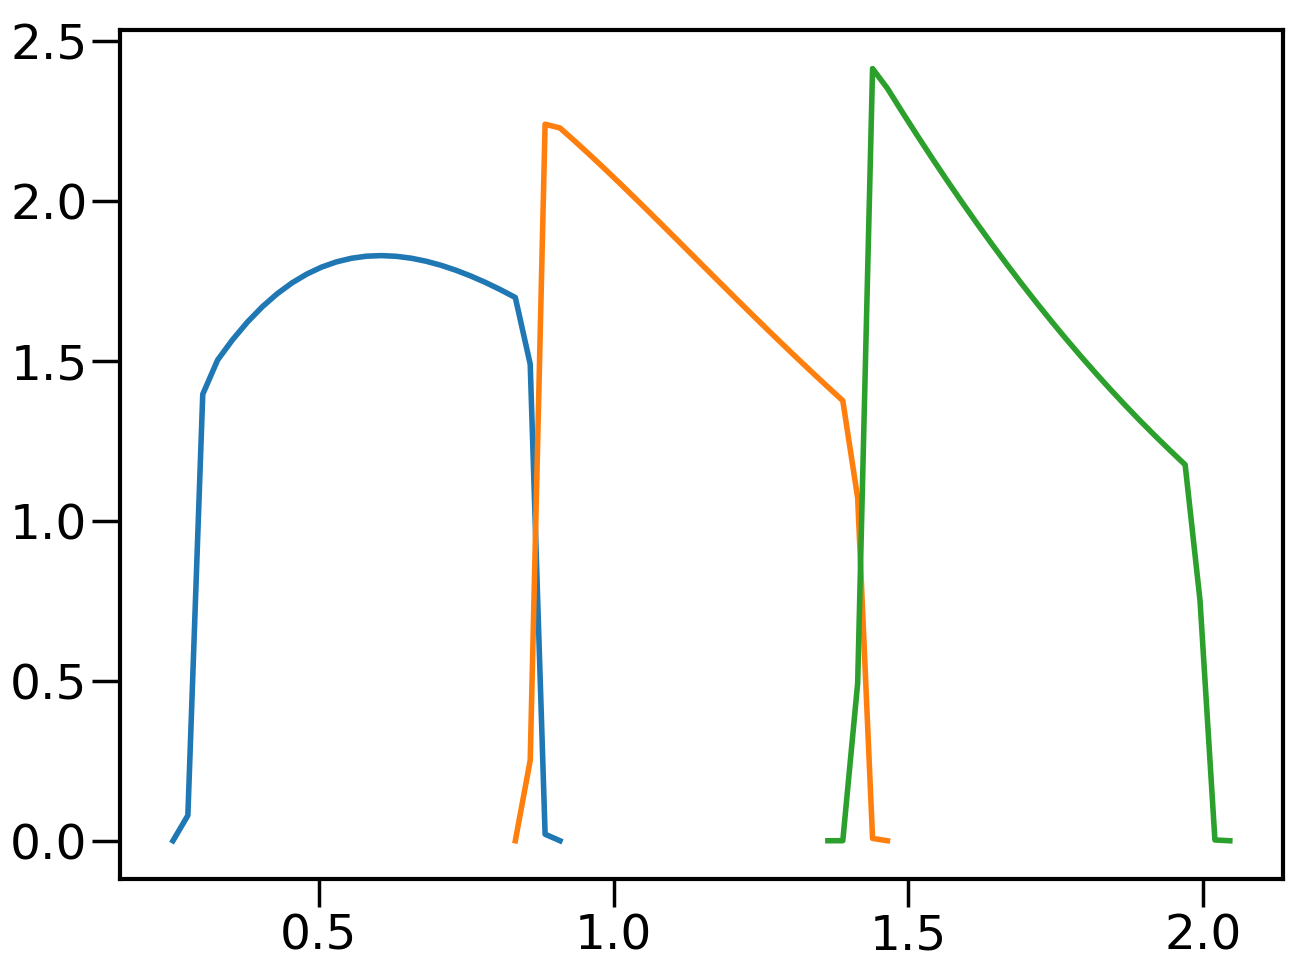

In [26]:
nb=kappaS.zs_bins['n_bins']
for i in np.arange(nb):
    zb=zs_bins[i] #kappaS.zs_bins[i]
    plot(zb['z'],zb['pz'])
    print(np.sum(zb['nz']))
# yscale('log')

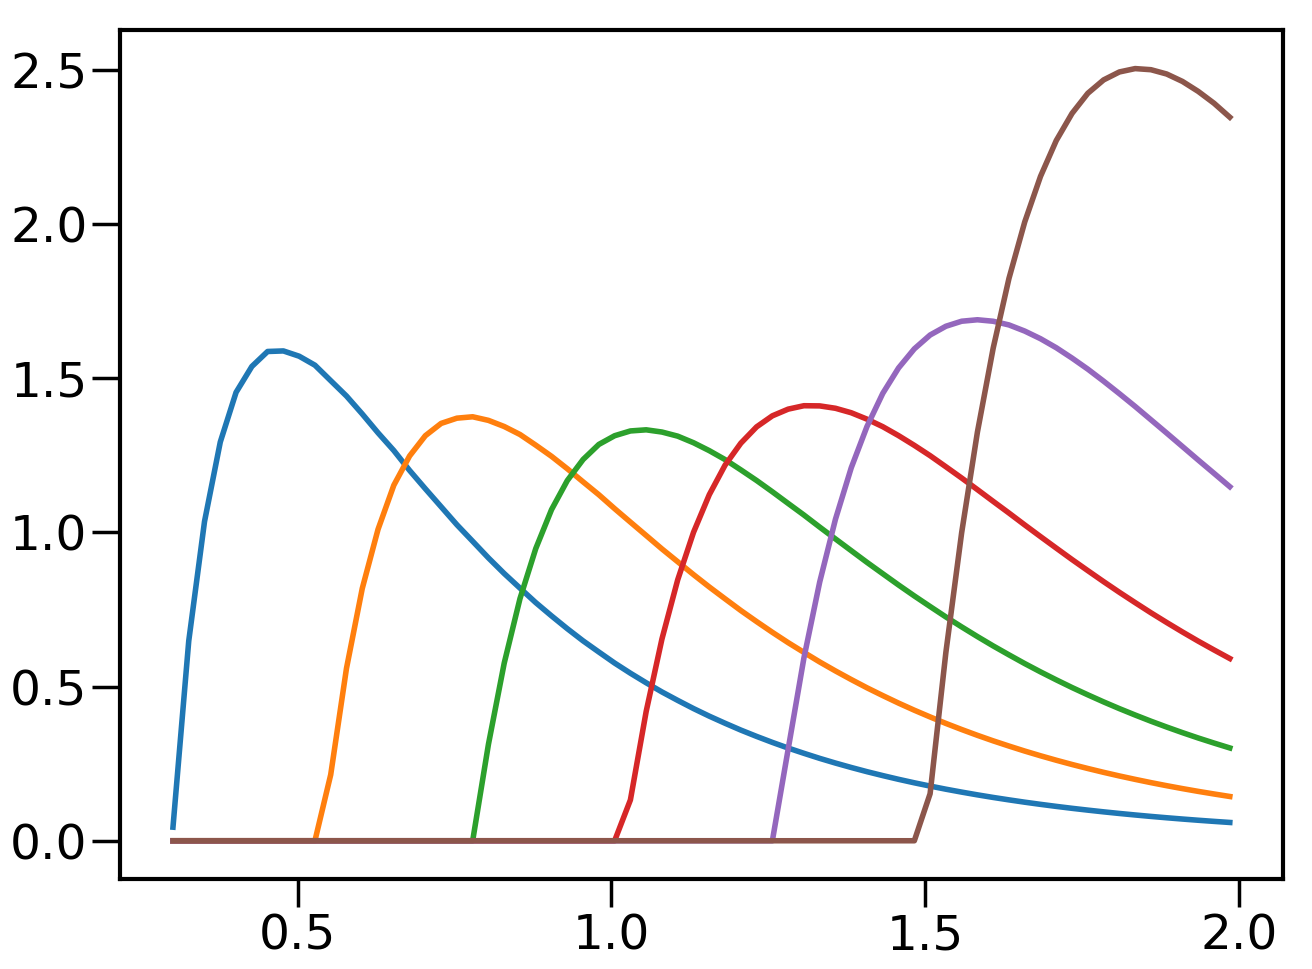

In [27]:
nb=kappaL.zs_bins['n_bins']
for i in np.arange(nb):
    zb=kappaL.zs_bins[i]
    plot(zb['z'],zb['pz'])
#     print(np.sum(zb['nz']))
#     print(zb['z'],zb['pz'])
# yscale('log')
# ylim(2.e-4,20)

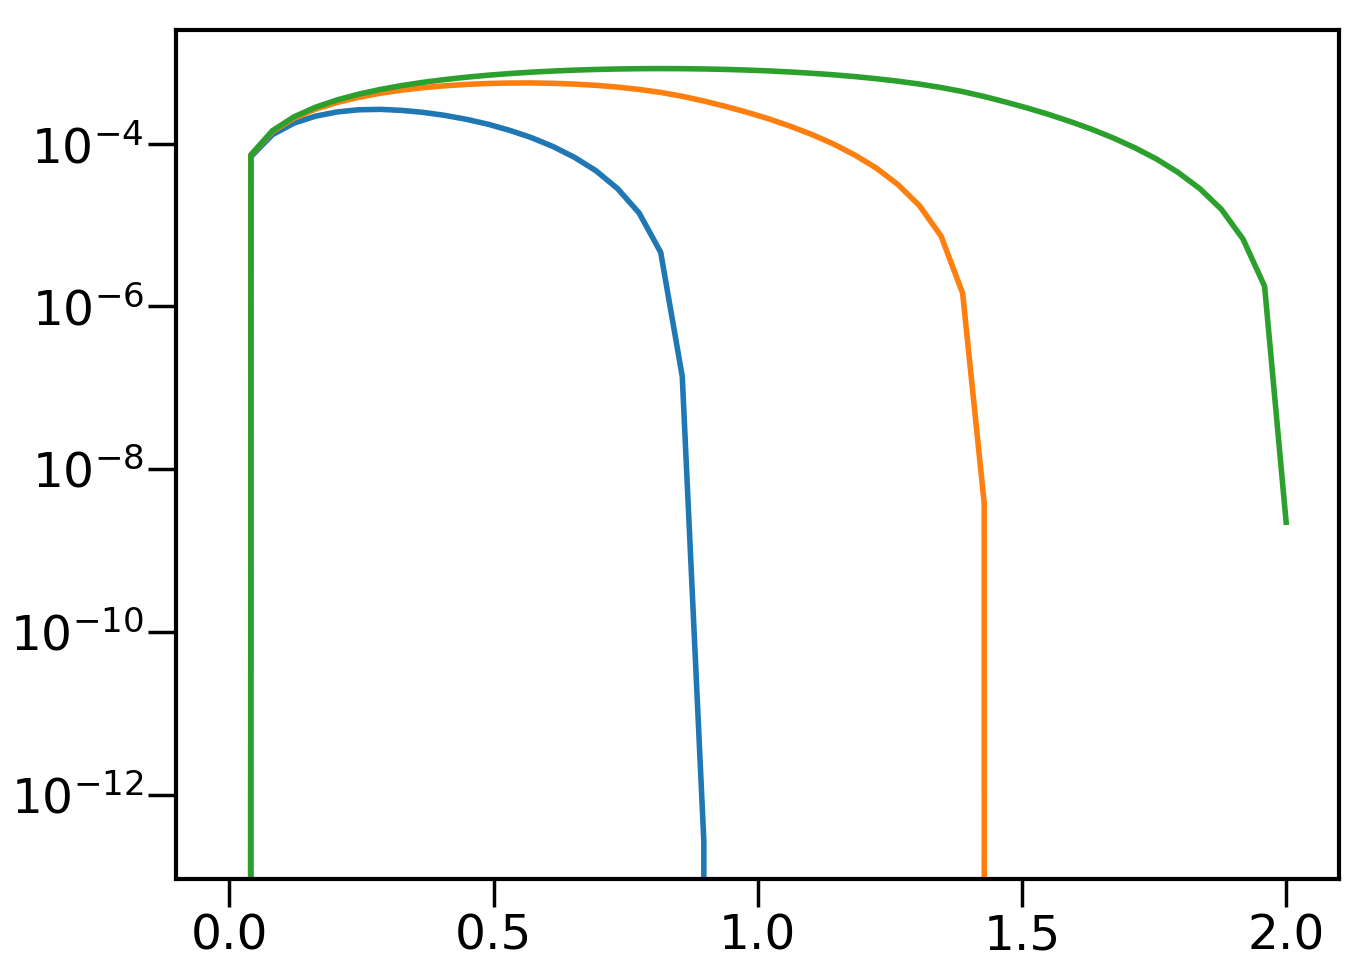

In [28]:
nb=kappaS.zs_bins['n_bins']
zl=kappaS.zs_bins['z_lens_kernel']
for i in np.arange(nb):
    zb=kappaS.zs_bins[i]
    plot(zl,zb['lens_kernel'])
#     print(np.sum(zb['nz']))
#     print(zb['z'],zb['pz'])
yscale('log')
# ylim(2.e-4,20)

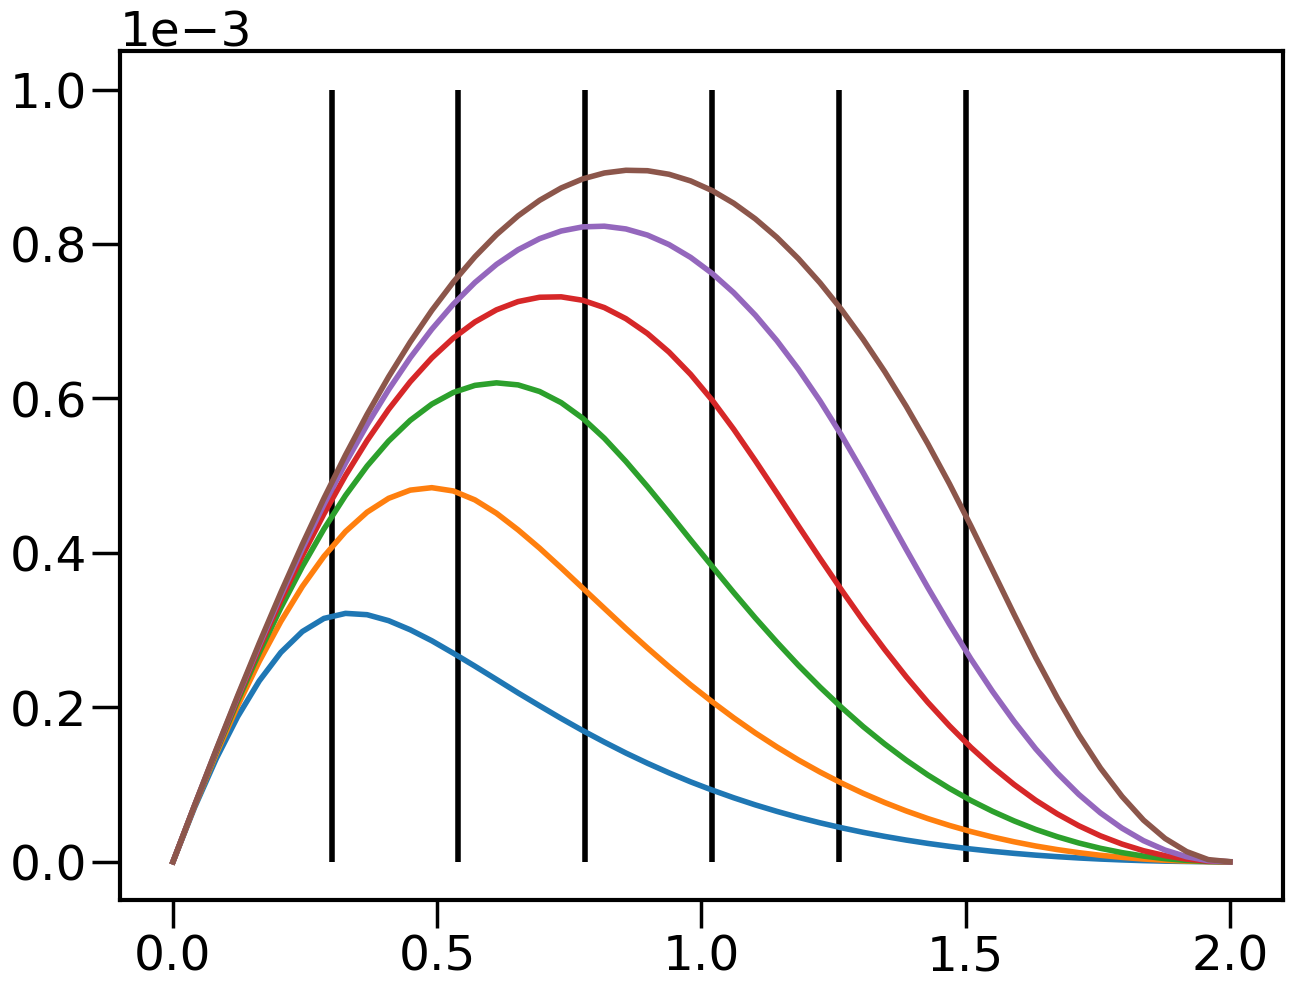

In [29]:
nb=kappaL.zs_bins['n_bins']
zb2=kappaL.zs_bins['z_bins']
zl=kappaL.zs_bins['z_lens_kernel']
for i in np.arange(nb):
    zb=kappaL.zs_bins[i]
    plot(zl,zb['lens_kernel'])
    vlines(zb2[i],0,1.e-3)
#     print(np.sum(zb['nz']))
#     print(zb['z'],zb['pz'])
# yscale('log')
# ylim(2.e-8,2.e-5)

In [30]:
%time clSG=kappaS.kappa_cl_tomo()
%time clLG=kappaL.kappa_cl_tomo()#kappa_cl_tomo()

CPU times: user 42.3 ms, sys: 4.16 ms, total: 46.5 ms
Wall time: 44.3 ms
CPU times: user 63.7 ms, sys: 2.77 ms, total: 66.5 ms
Wall time: 67.5 ms


In [31]:
%time clS=clSG['stack'].compute()
%time clL=clLG['stack'].compute()
covS_inv=np.linalg.inv(clS['cov'])
print (np.sqrt(np.dot(clS['cl'],np.dot(covS_inv,clS['cl']))))
covL_inv=np.linalg.inv(clL['cov'])
print (np.sqrt(np.dot(clL['cl'],np.dot(covL_inv,clL['cl']))))

CPU times: user 1min 9s, sys: 6.46 s, total: 1min 15s
Wall time: 1min 2s
CPU times: user 1min 9s, sys: 6.45 s, total: 1min 16s
Wall time: 1min
578.402670057
584.367342827


KeyboardInterrupt: 

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


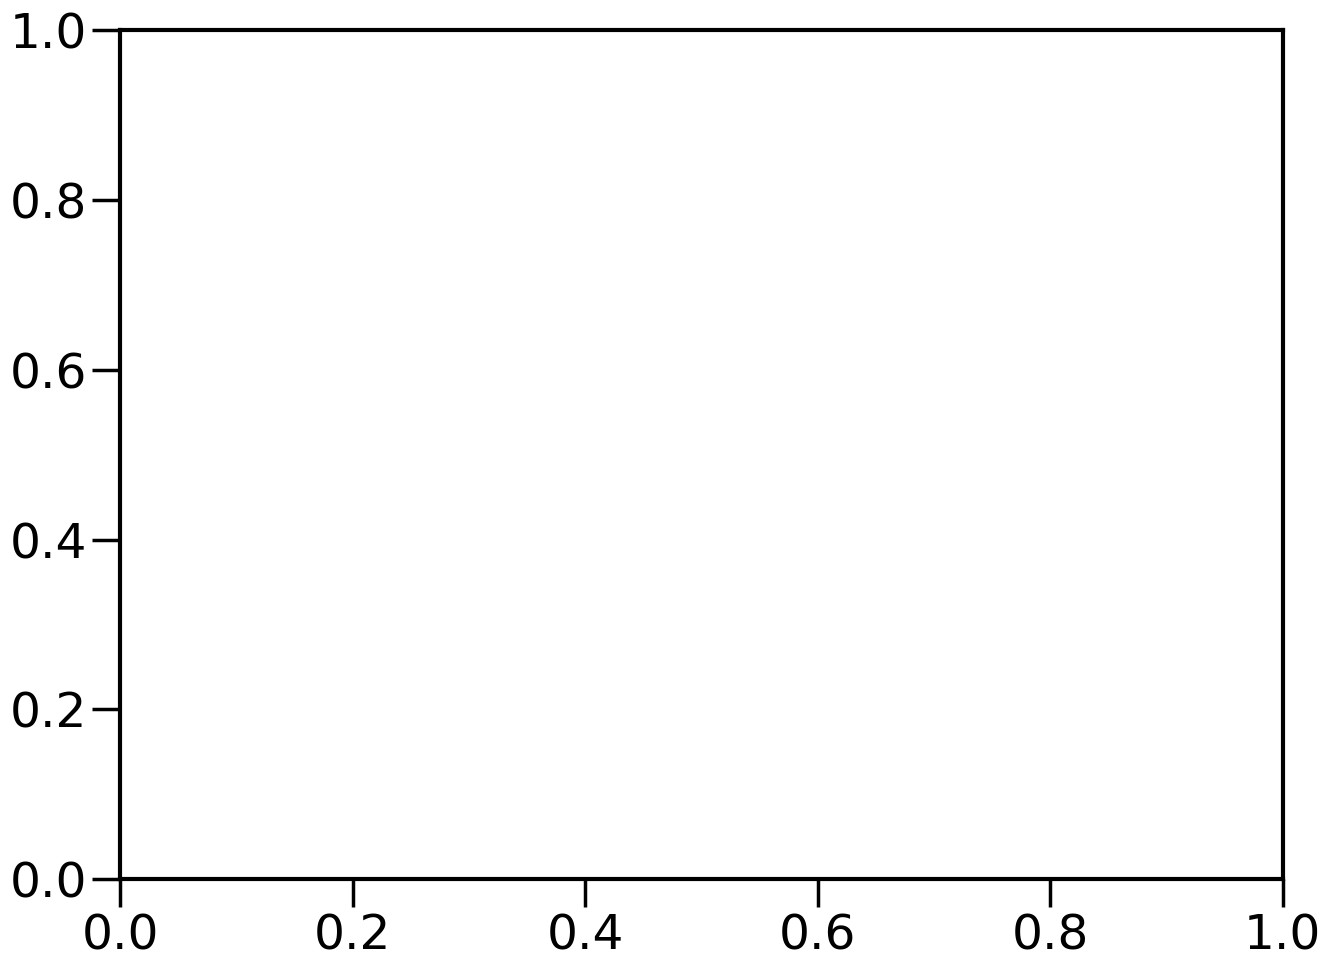

In [127]:
cc=kappaS.cov_utils
corrS=cc.corr_matrix(clS['cov'])
corrL=cc.corr_matrix(clL['cov'])
pcolor(corrS,vmin=-1,vmax=1,cmap='seismic')
show()
pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [ ]:
# %time clS['cl']=clSG['cl0'].compute()
clL['cli']=clLG['cl0'].compute()
clS['cli']=clSG['cl0'].compute()
# clS['cov']=clSG['cov0'].compute()
# clL['cov']=clLG['cov0'].compute()



In [ ]:
plot(lb,clS['cli'][:,0,0])
plot(lb,clL['cli'][:,0,0],'--')
xscale('log')
yscale('log')

ValueError: x and y must have same first dimension, but have shapes (39,) and (234,)

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


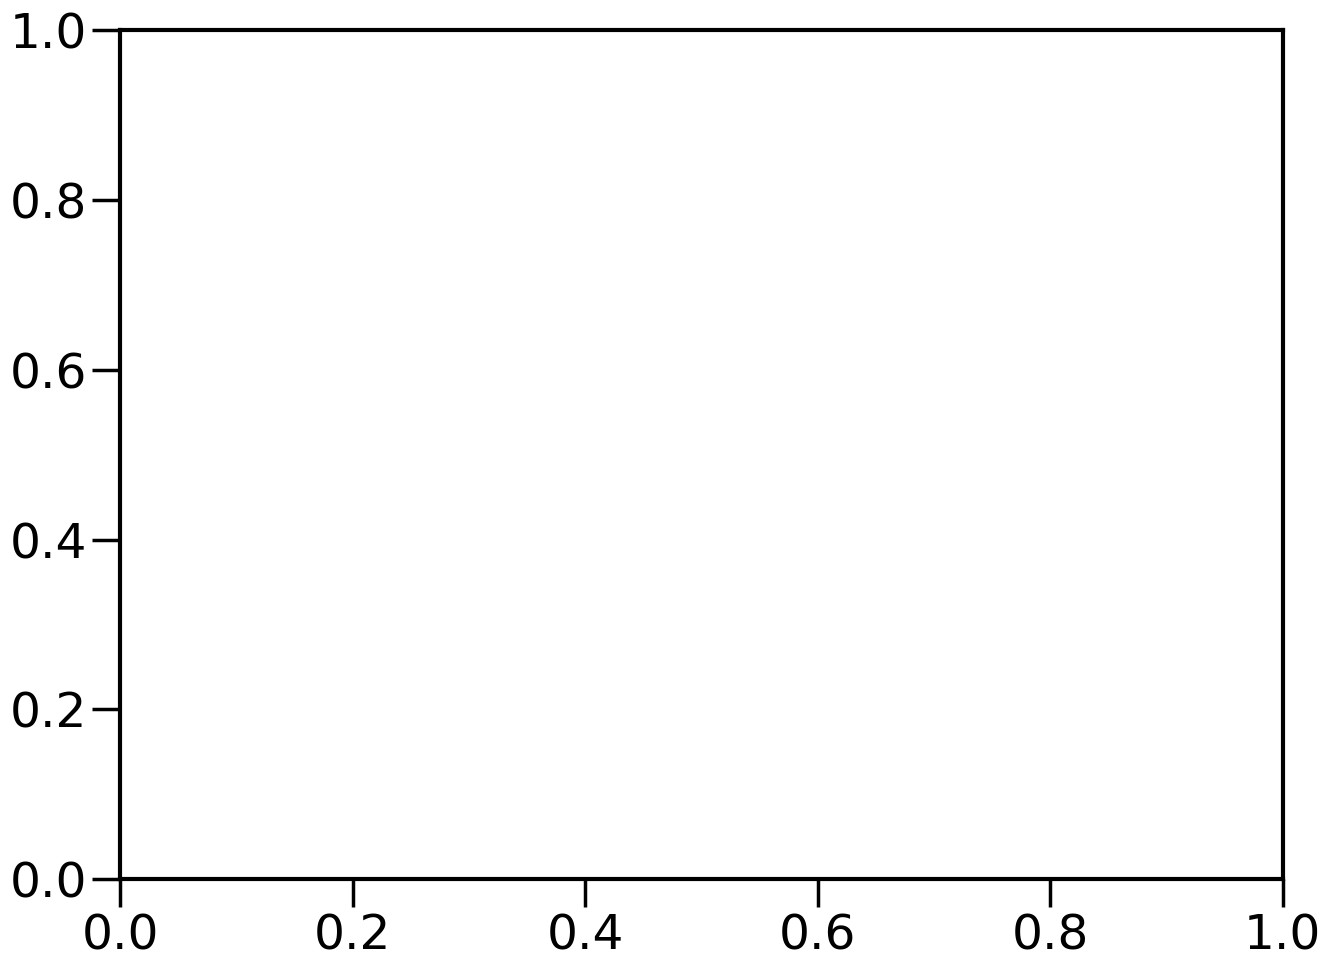

In [127]:
plot(lb,clS['cl'])
plot(lb,clL['cl'],'--')
xscale('log')
yscale('log')

In [ ]:
plot(l_bins[:-1],np.sqrt(np.diag(clS['cov'])))
plot(l_bins[:-1],np.sqrt(np.diag(clL['cov'])),'--')
xscale('log')
yscale('log')

In [ ]:
plot(l_bins[:-1],clS['cl']/np.sqrt(np.diag(clS['cov'])))
plot(l_bins[:-1],clL['cl']/np.sqrt(np.diag(clL['cov'])),'--')
xscale('log')
yscale('log')

In [ ]:
plot(l_bins[:-1],np.sqrt(np.diag(clS['cov']))/np.sqrt(np.diag(clL['cov'])))
plot(l_bins[:-1],clS['cl']/clL['cl'],'--')
xscale('log')
# yscale('log')

In [ ]:
plot(z,kappaL.zs_bins[0]['W'])

In [ ]:
xiSG['stack'].visualize()

In [ ]:
%time clSG=kappaS.kappa_cl_tomo()
clLG=kappaL.kappa_cl_tomo()#kappa_cl_tomo()
# %time clS=clSG['stack'].compute()
# %time clL=clLG['stack'].compute()

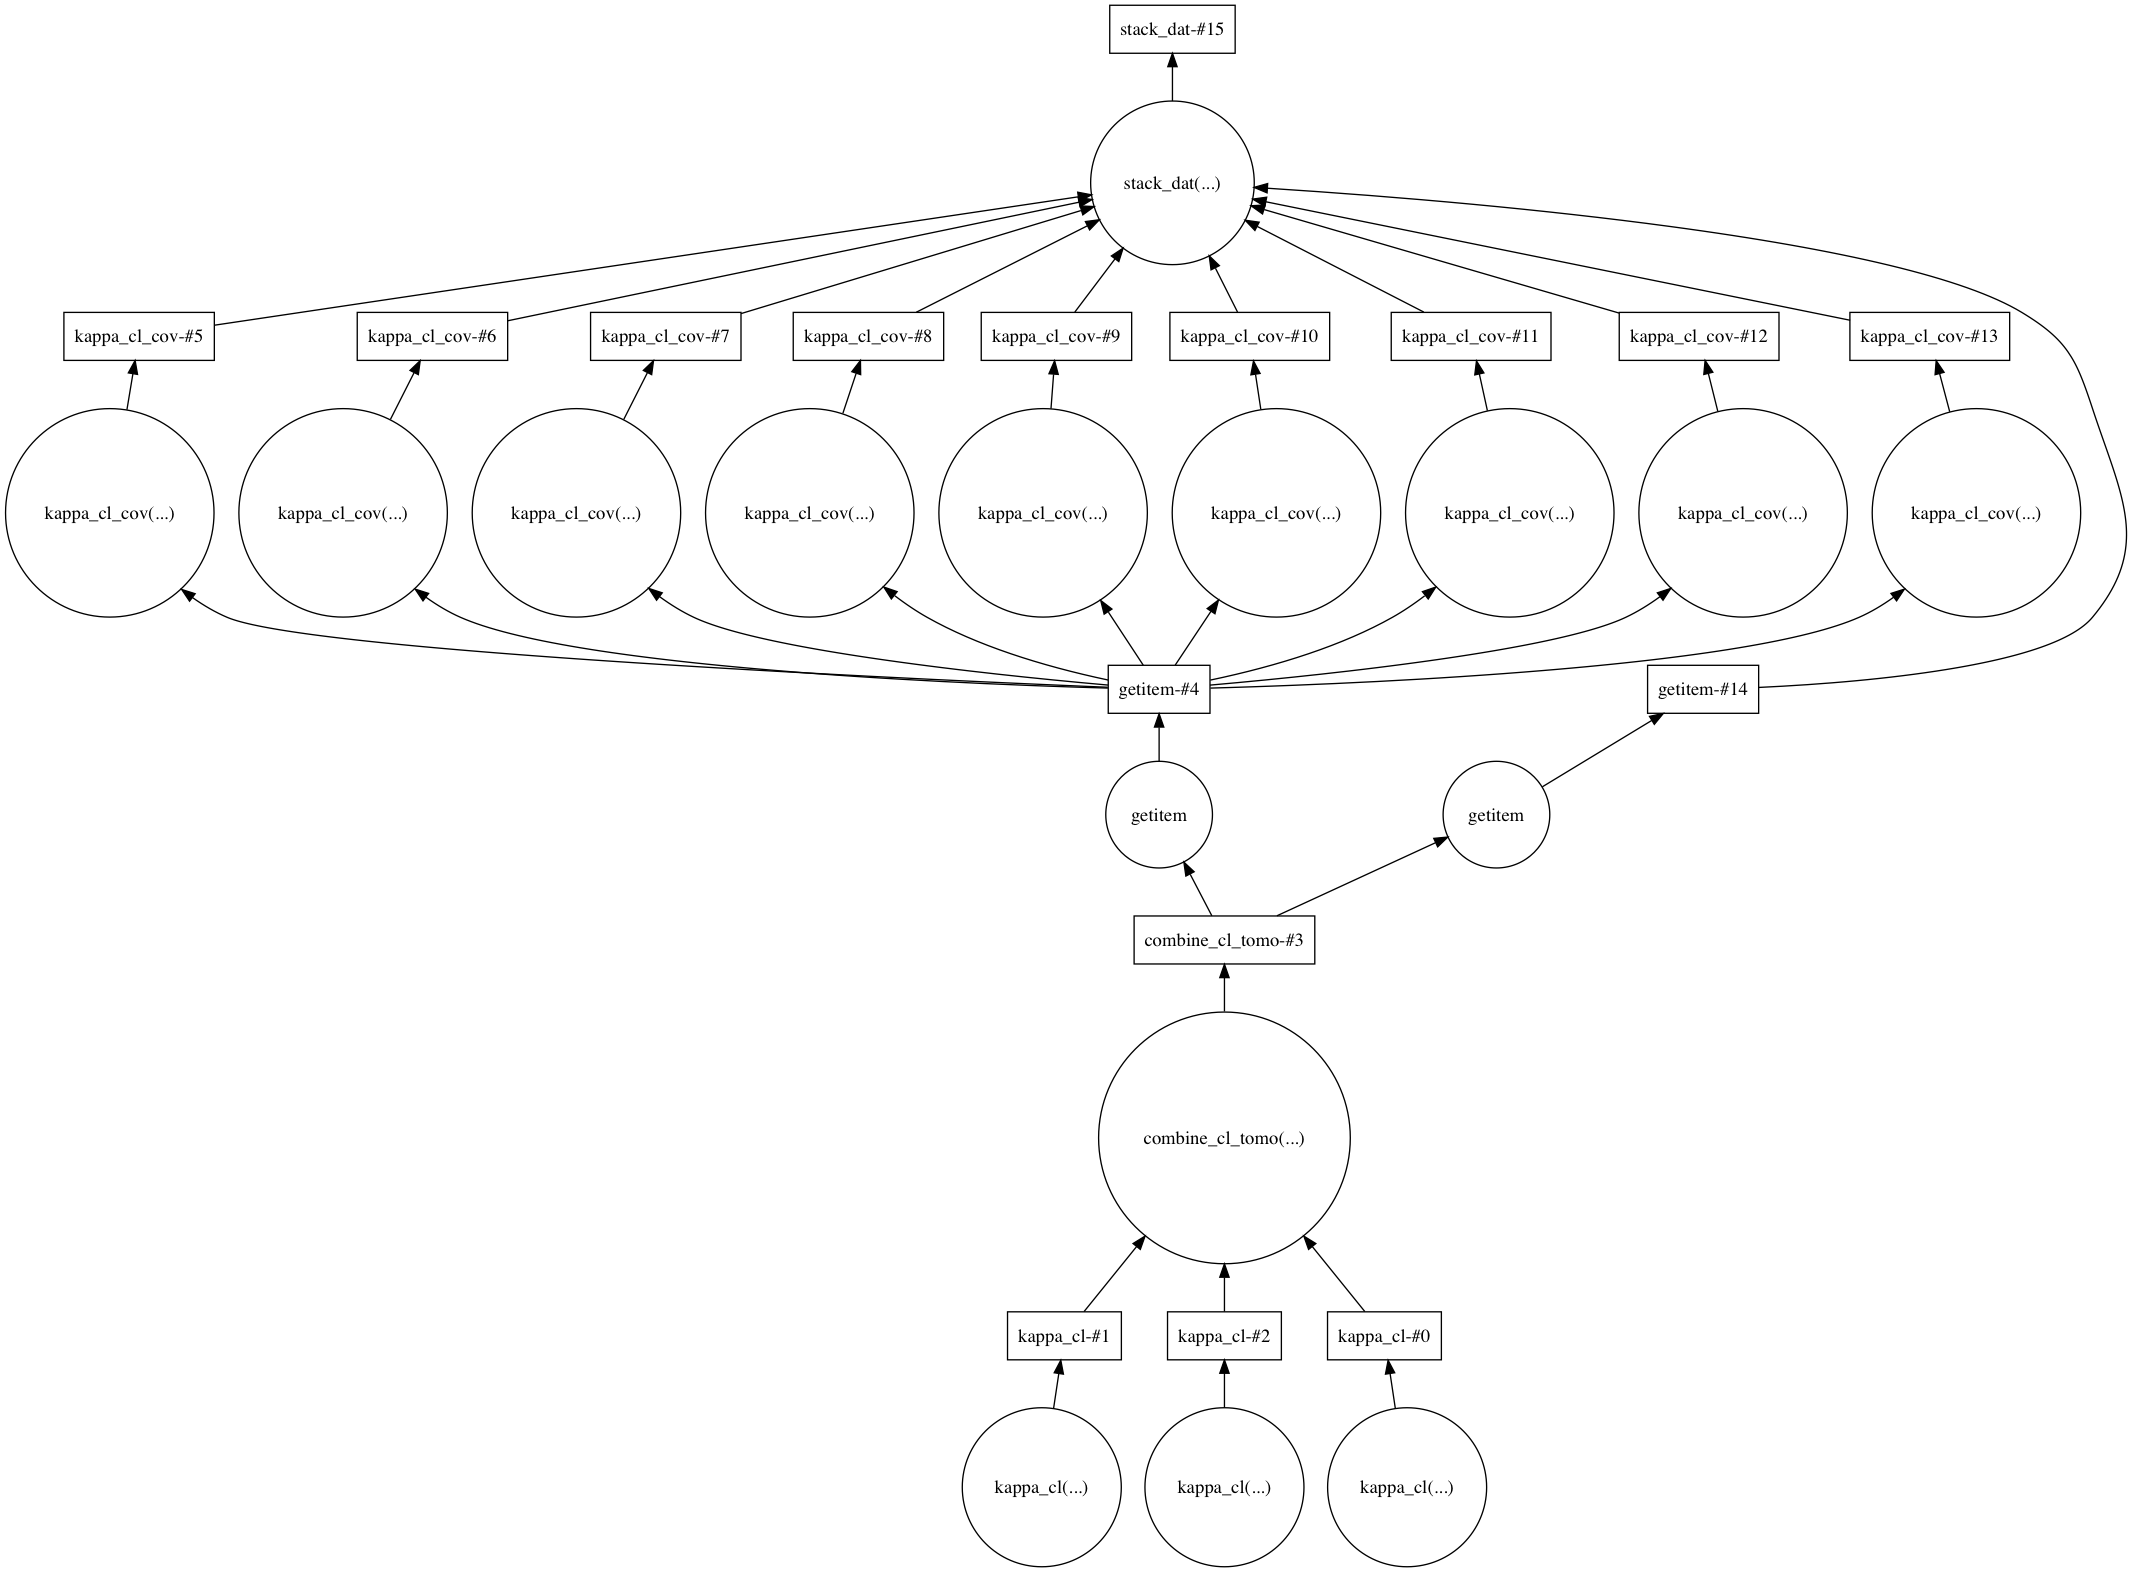

In [90]:
clSG['stack'].visualize()

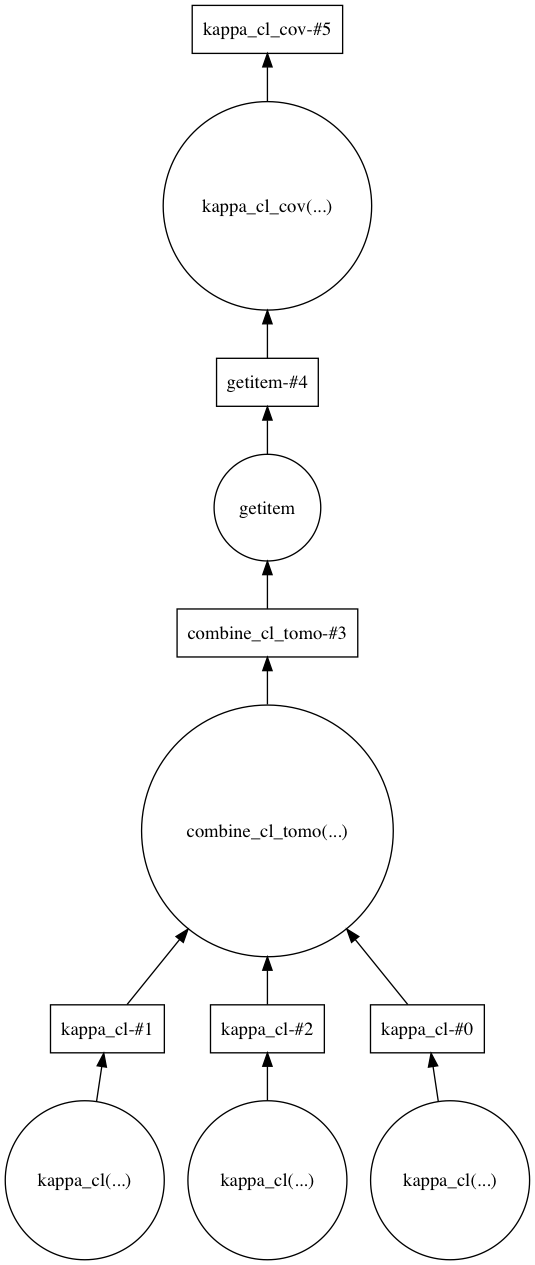

In [31]:
clSG['cov0'][(0,0,0,0)].visualize()

In [32]:
kappaS.SN

array([[[ 0.,  0.],
        [ 0.,  0.]]])

In [33]:
kappaL.SN

array([[[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]]])

In [128]:
cl_b_stack=clS#kappaS.stack_dat(clS)
cl_Lb_stack=clL#kappaL.stack_dat(clL)
#clstack=kappaS.stack_dat(clS)

In [129]:
covS_inv=np.linalg.inv(cl_b_stack['cov'])
print (np.sqrt(np.dot(cl_b_stack['cl'],np.dot(covS_inv,cl_b_stack['cl']))))
covL_inv=np.linalg.inv(cl_Lb_stack['cov'])
print (np.sqrt(np.dot(cl_Lb_stack['cl'],np.dot(covL_inv,cl_Lb_stack['cl']))))

286.807331994
353.652807689


/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


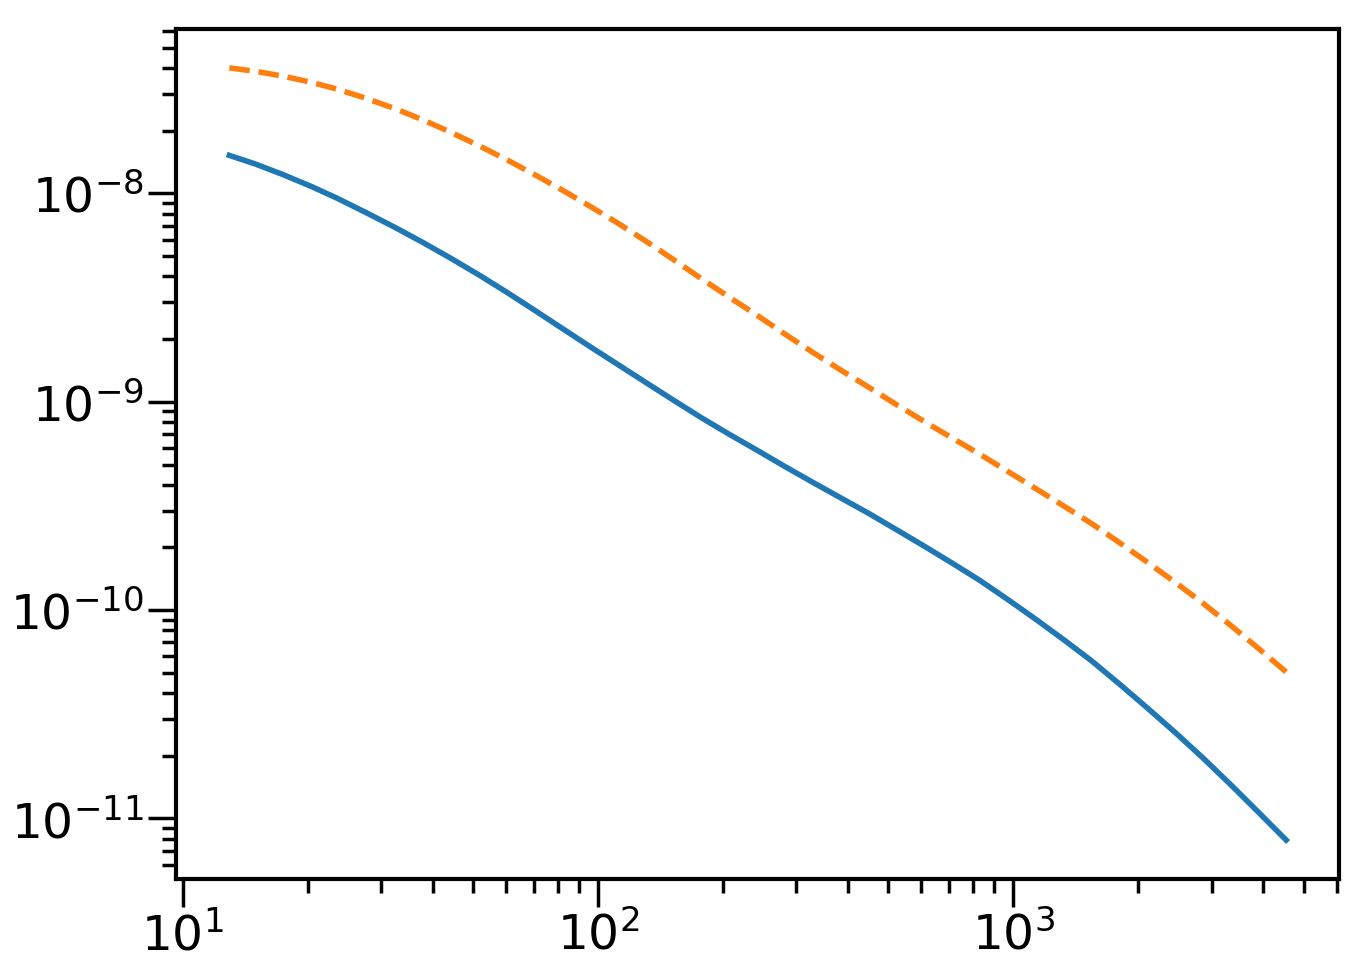

In [36]:
plot(clS['l'],clS['cl'][:,0,0])
#plot(clSb['l'],clSb['cl'][:,0,0])

plot(clL['l'],clL['cl'][:,0,0],ls='--')
# plot(clLb['l'],clLb['cl'][:,0,0])
xscale('log')
yscale('log')

(10, 3000)

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


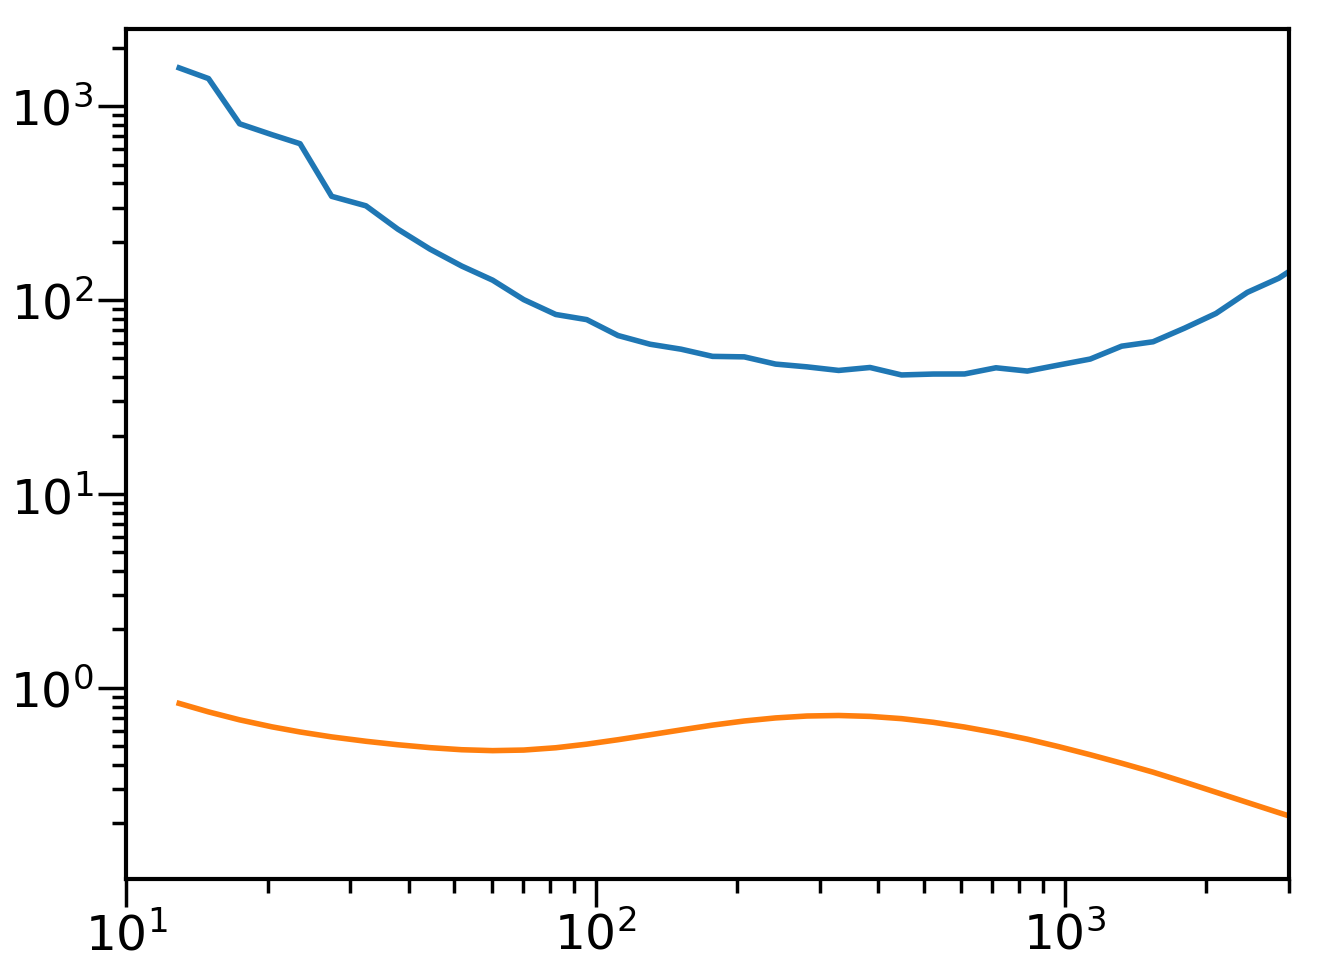

In [24]:
#cov0=clS['cov'][(0,0,0,0)]
f=1.e4
cl00=clSb
cl01=clS
cov0=cl00['cov'][(0,0,0,0)]
cov01=cl01['cov'][(0,0,0,0)]
cl_t=cl00['cl'][:,0,0]
cl_t1=cl01['cl'][:,0,0]
plot(lb,np.diag(cov0['G'])/cl_t**2*f)
plot(lb,np.diag(cov0['SSC_dd'])/cl_t**2*f)
# plot(l,np.diag(cov01['G'])/cl_t1**2*f)
# plot(l,np.diag(cov01['SSC_dd'])/cl_t1**2*f)
xscale('log')
yscale('log')
xlim(10,3000)

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


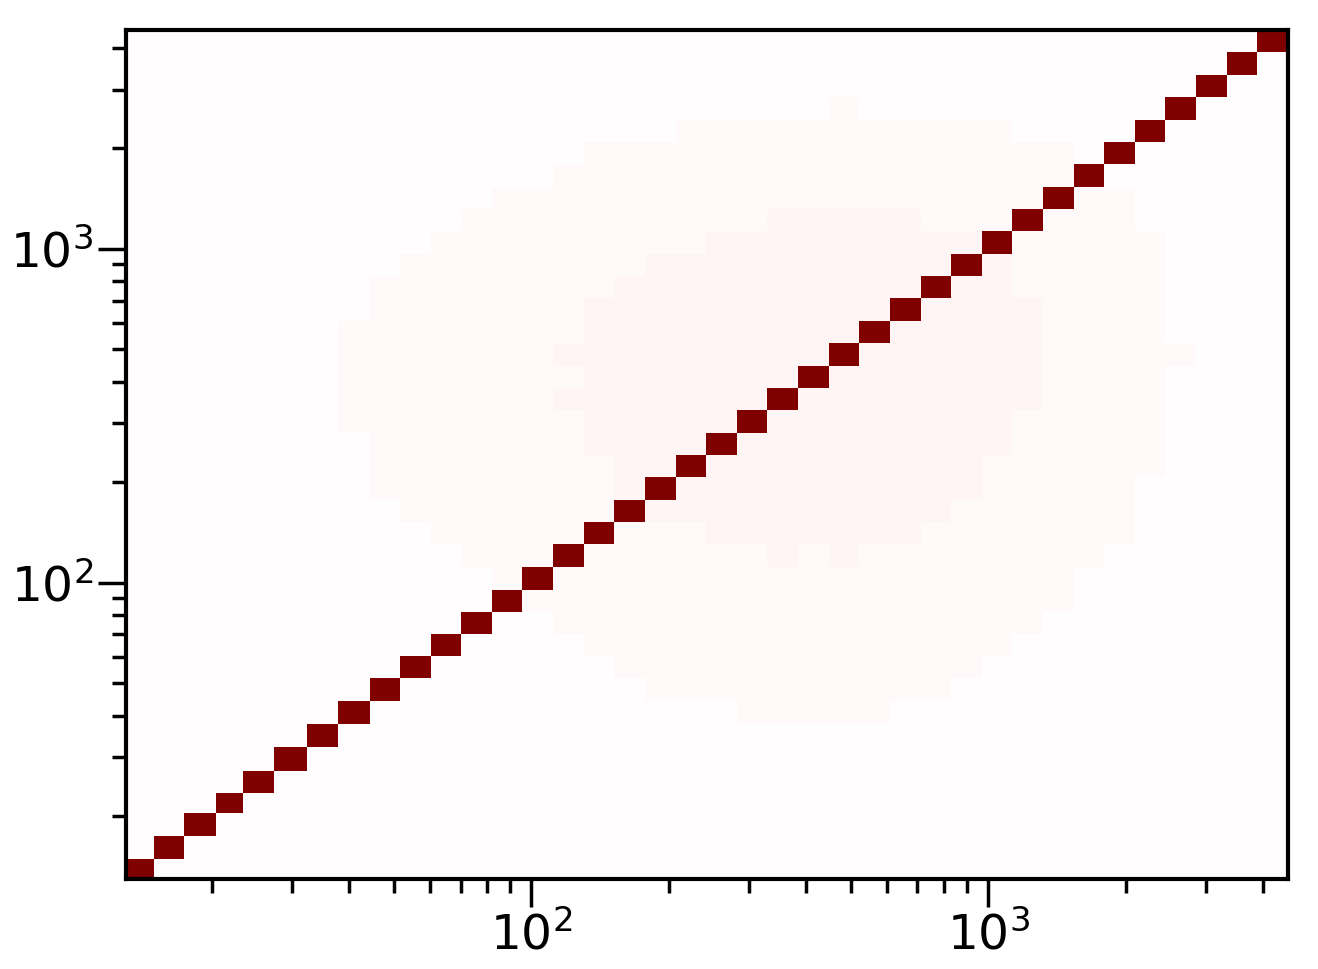

In [25]:
corr2=cc.corr_matrix(cov0['final'])
pcolor(lb,lb,corr2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')

(10, 3000)

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


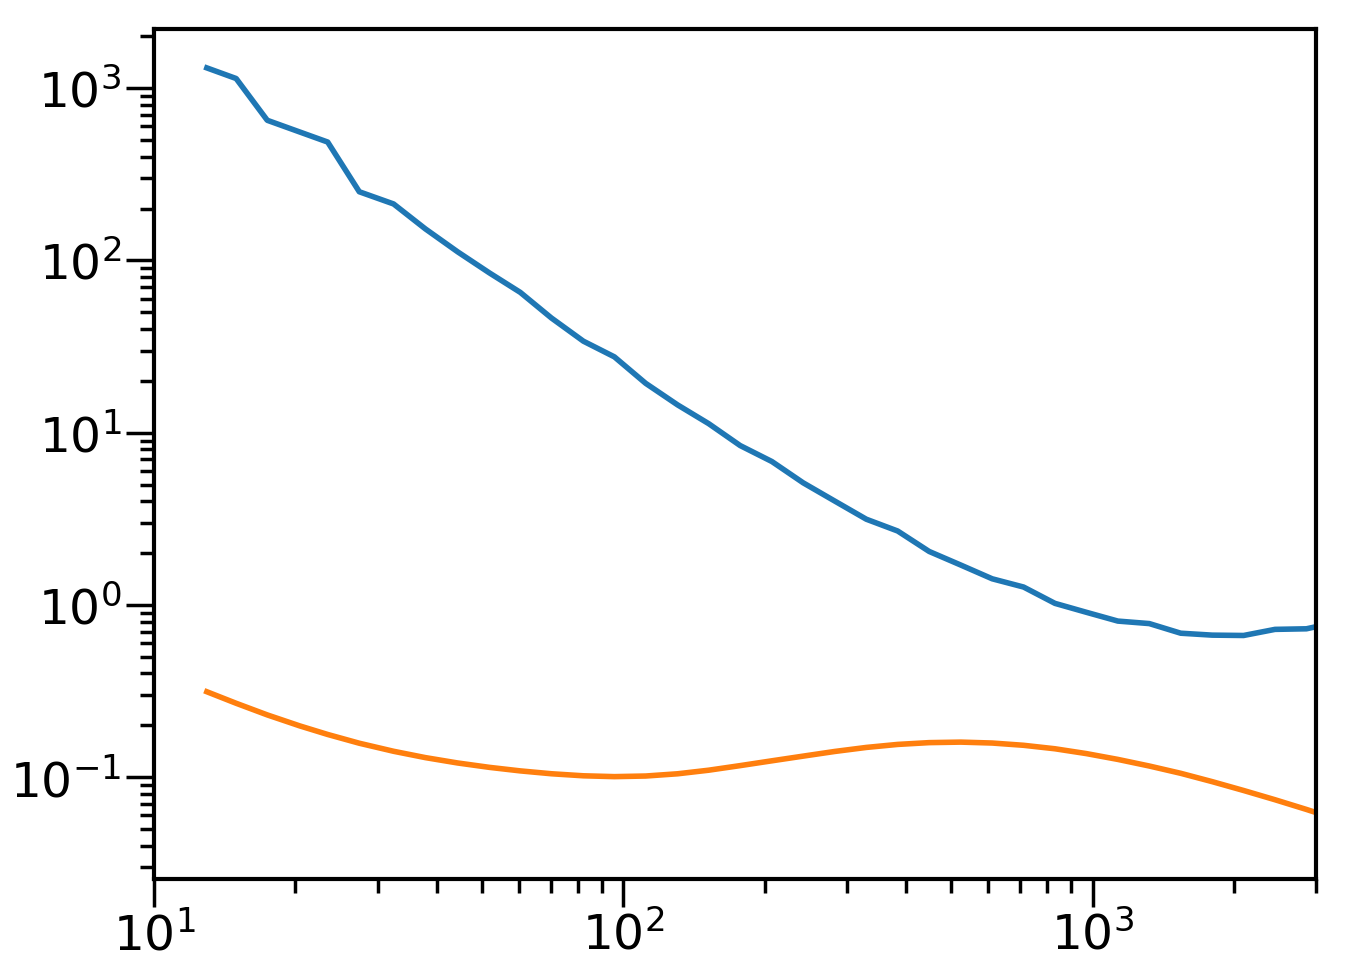

In [26]:
#cov0=clS['cov'][(0,0,0,0)]
f=1.e4
cl00=clLb
cl01=clL
cov0=cl00['cov'][(0,0,0,0)]
cov01=cl01['cov'][(0,0,0,0)]
cl_t=cl00['cl'][:,0,0]
cl_t1=cl01['cl'][:,0,0]
plot(lb,np.diag(cov0['G'])/cl_t**2*f)
plot(lb,np.diag(cov0['SSC_dd'])/cl_t**2*f)
# plot(l,np.diag(cov01['G'])/cl_t1**2*f)
# plot(l,np.diag(cov01['SSC_dd'])/cl_t1**2*f)
xscale('log')
yscale('log')
xlim(10,3000)

In [66]:
x=np.linspace(1,2,10+1)

for i in np.arange(10):
    x[i:i+2]

In [227]:
from astropy.cosmology import Planck15 as cosmo
cosmo_h=cosmo.clone(H0=100)

In [251]:
sc=lu.sigma_crit(zl=zl,zs=zs,cosmo_h=cosmo_h)
np.sum(sc,axis=1)

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/astropy/units/quantity.py:968: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__rtruediv__(other)


array([ inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf])

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/astropy/units/quantity.py:968: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__rtruediv__(other)
/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


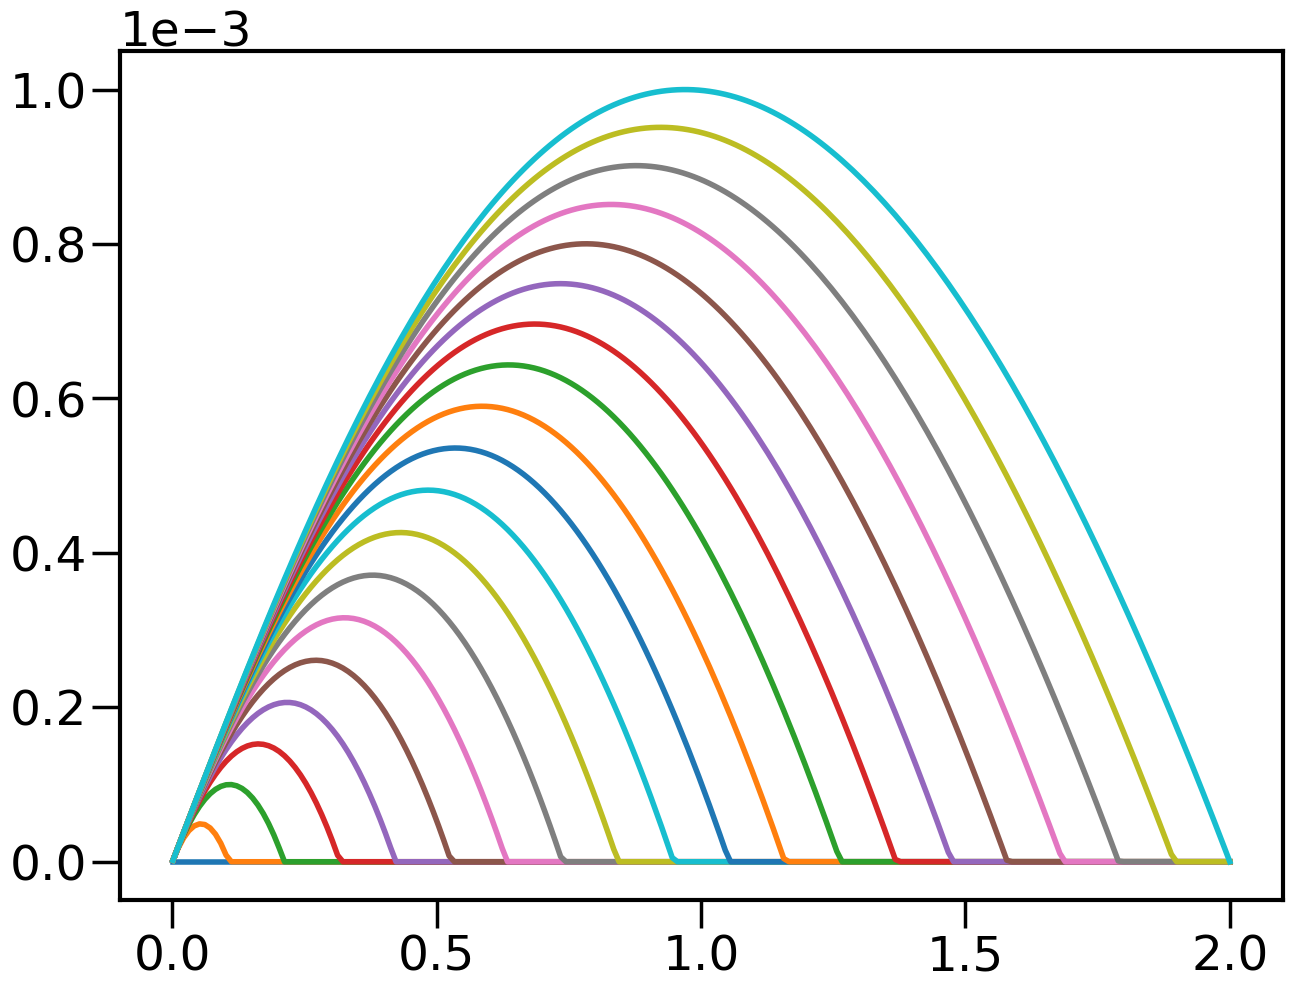

In [229]:
lu=Lensing_utils()
zl=np.linspace(0.001,2,200)
zs=np.linspace(0.001,2,20)

for z in zs:
    sc=lu.sigma_crit(zl=zl,zs=z,cosmo_h=cosmo_h)
    plot(zl,1./sc)

In [1]:
import power_spectra
reload(power_spectra)

NameError: name 'reload' is not defined

In [5]:
from power_spectra import *
PS=Power_Spectra()
%time pk,k=PS.class_pk(z=[0,1])

CPU times: user 4.42 s, sys: 141 ms, total: 4.56 s
Wall time: 5.88 s


In [10]:
PS2=Power_Spectra()
params2=PS2.cosmo_params.copy()
params2['w']=-0.9
params2['wa']=-0.2
%time pk2,k=PS2.class_pk(z=[0,1],cosmo_params=params2)

CPU times: user 5.17 s, sys: 144 ms, total: 5.31 s
Wall time: 5.57 s


/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


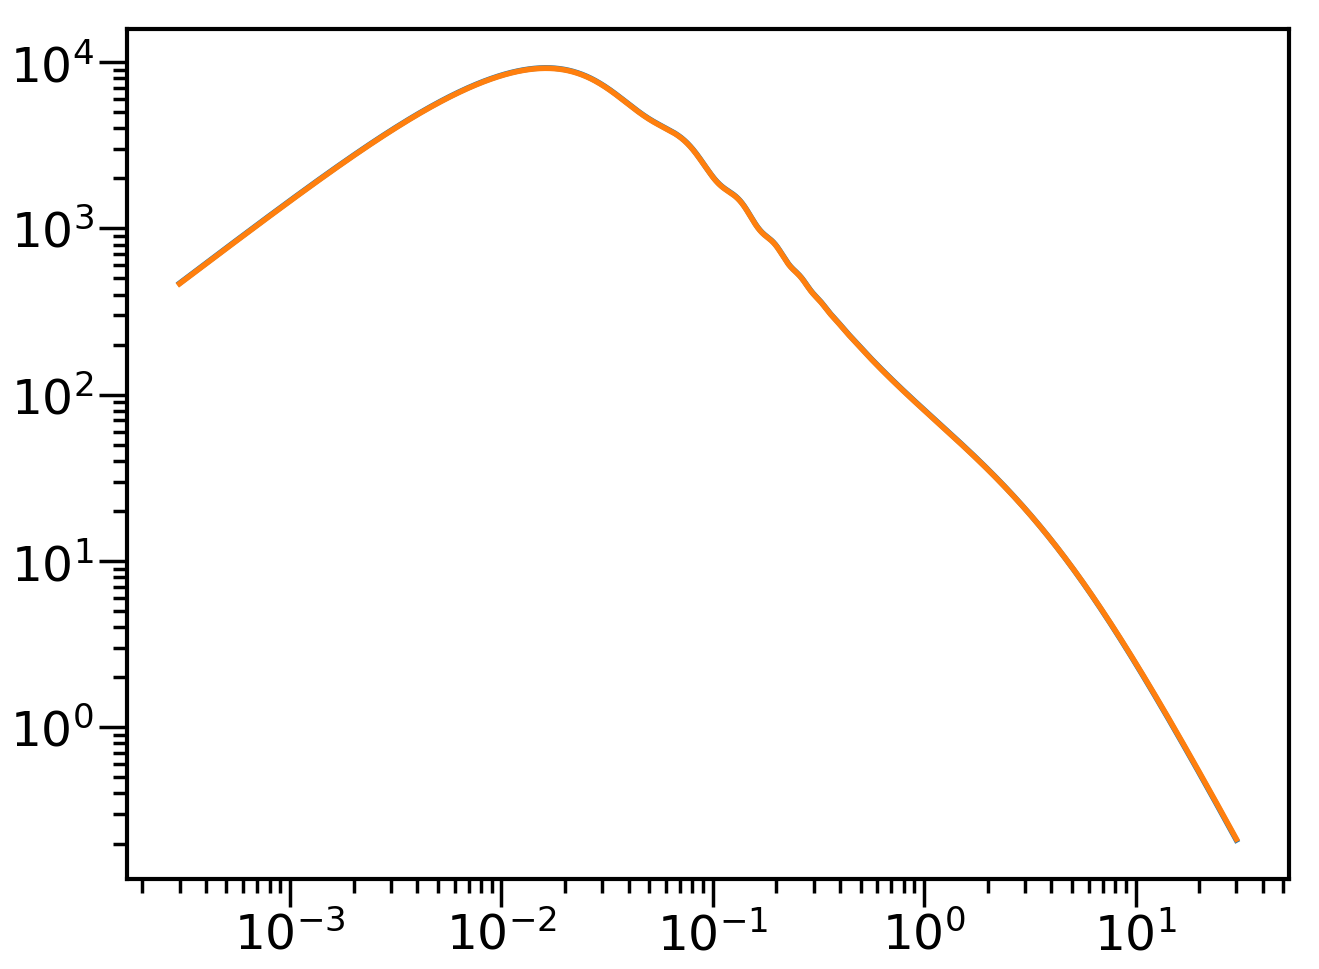

In [11]:
plot(k,pk[1])
plot(k,pk2[1]*1)
xscale('log')
yscale('log')

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


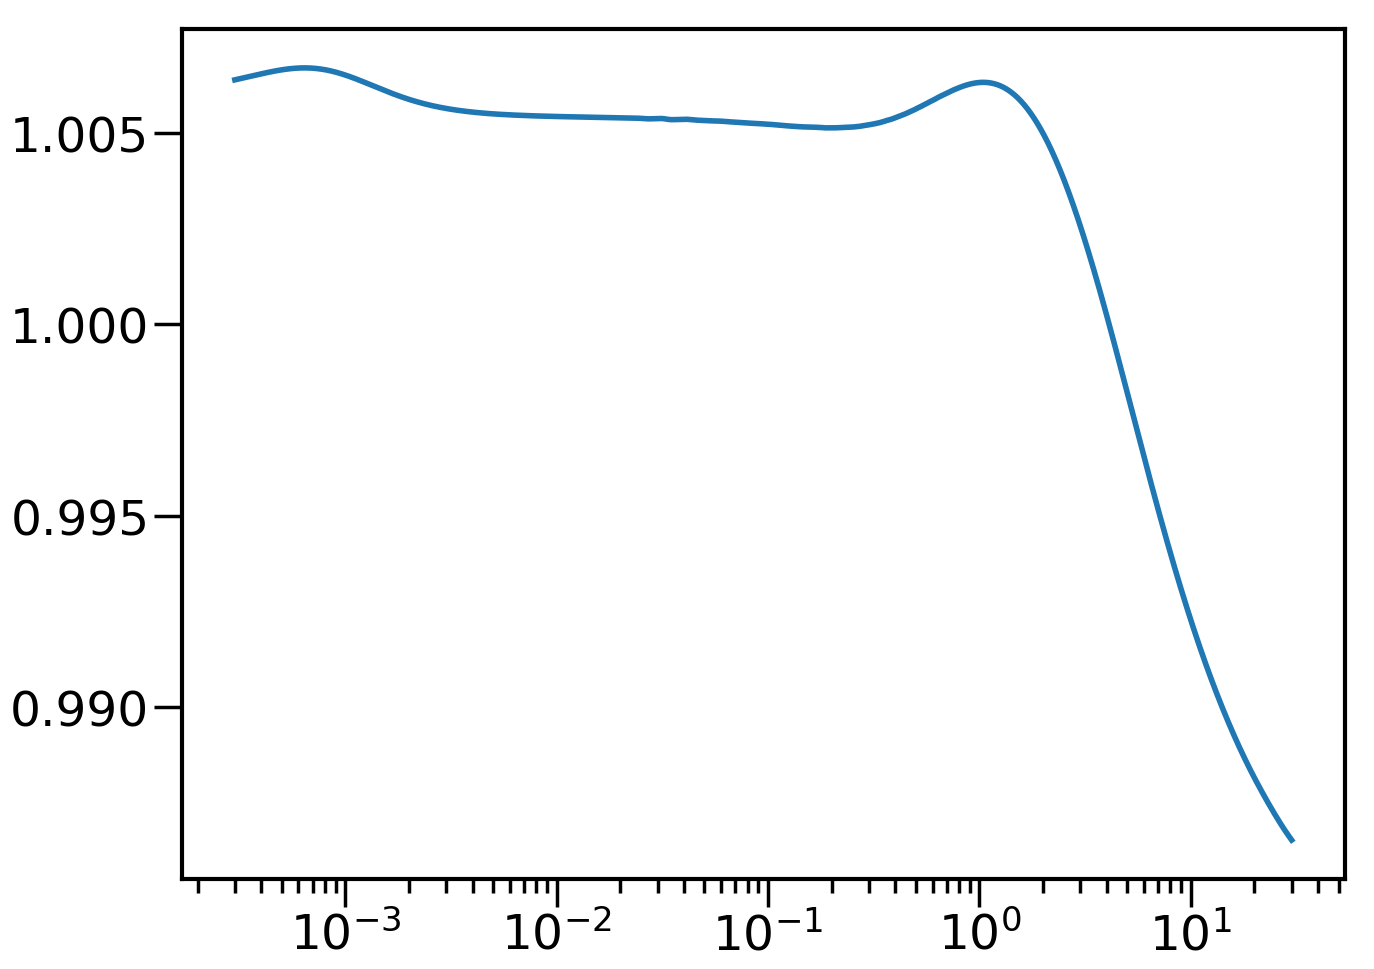

In [13]:
plot(k,pk[1]/pk2[1])
xscale('log')
# yscale('log')